# **Projet 7 :** Implémentez un modèle de scoring

## Notebook du choix du modèle de scoring

### Import

In [1]:
import os

# check scikit-learn version
import sklearn
print(sklearn.__version__)

1.1.1


In [2]:
%pylab inline
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


### Configuration

In [3]:
%load_ext autoreload
%autoreload 2

# configurations pandas
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

import warnings
warnings.filterwarnings("ignore")

### Chargement des données

In [4]:
path = './data'
filename = 'Home_Credit_Default_Risk.csv'
data = pd.read_csv(os.path.join(path, filename))
print(data.shape)

(356255, 425)


In [5]:
data_sampling = data.sample(frac=0.1, random_state=42)

### Test de LightGBM (Kernel Kagle)

In [6]:
import gc
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score

path = './data'
test_filename = 'Test_Home_Credit_Default_Risk.csv'
image_filename = 'Feature_Importance_LightGBM.png'

# Display/plot feature importance
def display_importances(feature_importance_df_, debug=False):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False), order=cols)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    if not debug:
        plt.savefig(os.path.join(path, image_filename))

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified=False, debug=False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()].copy()
    test_df = df[df['TARGET'].isnull()].copy()
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            n_jobs=8,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.6,  # 0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1,
            force_row_wise=True
        )

        log_evaluation_clb = log_evaluation(period=200)
        early_stopping_clb = early_stopping(stopping_rounds=200)
        clf.fit(
            train_x,
            train_y,
            eval_set=[(train_x, train_y), (valid_x, valid_y)],
            eval_metric='auc',
            callbacks=[early_stopping_clb, log_evaluation_clb]
        )

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(path, test_filename), index=False)

    display_importances(feature_importance_df, debug=debug)
    return feature_importance_df

Starting LightGBM. Train shape: (30846, 425), test shape: (4780, 425)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.867334	training's binary_logloss: 0.216124	valid_1's auc: 0.743922	valid_1's binary_logloss: 0.252913
[400]	training's auc: 0.910685	training's binary_logloss: 0.193713	valid_1's auc: 0.745769	valid_1's binary_logloss: 0.251898
Early stopping, best iteration is:
[312]	training's auc: 0.8937	training's binary_logloss: 0.202581	valid_1's auc: 0.746136	valid_1's binary_logloss: 0.251818
Fold  1 AUC : 0.746136
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.86504	training's binary_logloss: 0.216146	valid_1's auc: 0.744107	valid_1's binary_logloss: 0.253102
[400]	training's auc: 0.907207	training's binary_logloss: 0.194778	valid_1's auc: 0.746499	valid_1's binary_logloss: 0.25165
[600]	training's auc: 0.935452	training's binary_logloss: 0.178235	valid_1's auc: 0.74586	valid_1's binary_logloss: 0.2519

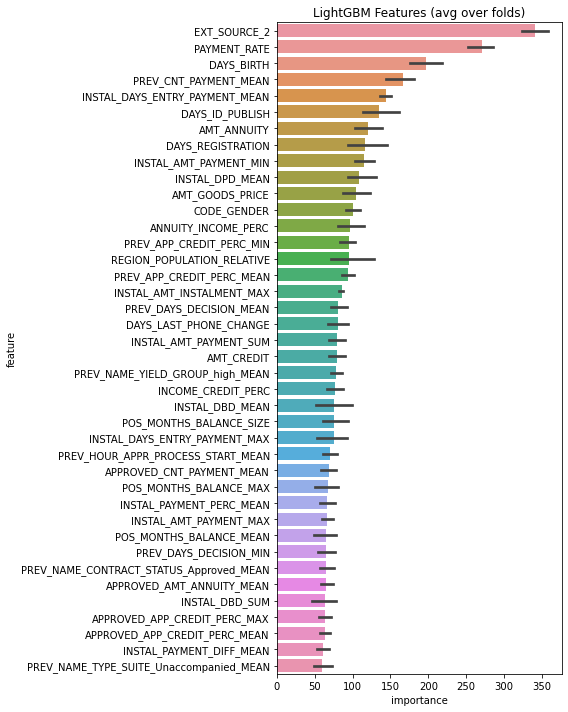

In [7]:
feature_importance_df = kfold_lightgbm(data_sampling, num_folds=4, stratified=False, debug=True)

Starting LightGBM. Train shape: (30846, 425), test shape: (4780, 425)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.862919	training's binary_logloss: 0.218029	valid_1's auc: 0.749127	valid_1's binary_logloss: 0.248615
[400]	training's auc: 0.907815	training's binary_logloss: 0.195258	valid_1's auc: 0.754375	valid_1's binary_logloss: 0.246677
[600]	training's auc: 0.933878	training's binary_logloss: 0.179564	valid_1's auc: 0.75204	valid_1's binary_logloss: 0.247327
Early stopping, best iteration is:
[423]	training's auc: 0.911753	training's binary_logloss: 0.193093	valid_1's auc: 0.754479	valid_1's binary_logloss: 0.246666
Fold  1 AUC : 0.754479
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.868786	training's binary_logloss: 0.215662	valid_1's auc: 0.728946	valid_1's binary_logloss: 0.253133
[400]	training's auc: 0.908833	training's binary_logloss: 0.193882	valid_1's auc: 0.730834	valid_1's binary_logloss: 0.

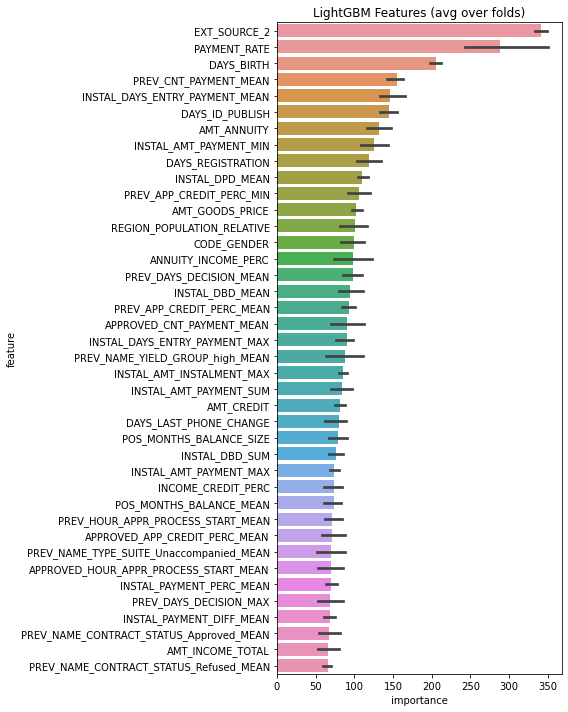

In [8]:
feature_importance_df = kfold_lightgbm(data_sampling, num_folds=4, stratified=True, debug=True)

### Fonction communes

In [9]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter

def train_test_split(_df):
    # Divide in training/validation and test data
    _train_df = _df[_df['TARGET'].notnull()]
    _test_df = _df[_df['TARGET'].isnull()]
    print("Train shape: {}, test shape: {}".format(_train_df.shape, _test_df.shape))
    counter = Counter(_train_df['TARGET'])
    print("Conteur de class", counter)
    return _train_df, _test_df

def feats_target_split(_df):
    feats = [f for f in _df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
    _X = _df[feats].copy()
    _y = _df['TARGET'].copy()
    return _X, _y

def gscv_classifier(_X, _y, _gridParams, _clf):
    print("Starting {}".format(_clf.__class__.__name__))
    _grid = GridSearchCV(_clf, _gridParams, scoring='roc_auc', verbose=2, cv=4)

    # Run the grid
    _grid.fit(_X, _y)

    # Print the best parameters found
    print("Best params:", _grid.best_params_)
    print("Best score:", _grid.best_score_)

    return _grid

In [10]:
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

def _plot_classifier(X, y, clf, title=None, folds=5, stratified=True):
    print("Ploting {}".format(clf.__class__.__name__))
    
    if stratified:
        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)
    else:
        cv = KFold(n_splits=folds, shuffle=True, random_state=1)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    oof_preds = np.zeros(X.shape[0])
    feature_importance_df = pd.DataFrame()

    fig, axs = plt.subplots(2, figsize=(15, 20))
    for i, (train, test) in enumerate(cv.split(X, y)):
        train_x, train_y = X.iloc[train], y.iloc[train]
        valid_x, valid_y = X.iloc[test], y.iloc[test]

        clf.fit(train_x, train_y)
        viz = RocCurveDisplay.from_estimator(clf, valid_x, valid_y, name="ROC fold {}".format(i), alpha=0.3, lw=1, ax=axs[1])
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        if isinstance(clf, XGBClassifier):
            oof_preds[test] = clf.predict_proba(valid_x, iteration_range=(0, clf.best_iteration))[:, 1]
        elif isinstance(clf, LGBMClassifier):
            oof_preds[test] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        else:
            oof_preds[test] = clf.predict_proba(valid_x)[:, 1]
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (i + 1, roc_auc_score(valid_y, oof_preds[test])))

    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False), order=cols, ax=axs[0])
    axs[0].set_title('{} Feature Importance (avg over folds)'.format(clf.__class__.__name__))

    axs[1].plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    axs[1].plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    axs[1].fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

    axs[1].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="{} ROC Curve".format(clf.__class__.__name__))
    axs[1].legend(loc="lower right")

    if title:
        plt.suptitle(title, y=1, fontweight ="bold")
    fig.tight_layout()
    plt.show()

In [11]:
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def plot_balanced_classifier(_X, _y, clf, title=None, folds=5, stratified=True, oversample=False, overparams={}, undersample=False, underparams={}):
    print("Ploting {}".format(clf.__class__.__name__))
    
    if stratified:
        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)
    else:
        cv = KFold(n_splits=folds, shuffle=True, random_state=1)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    oof_preds = np.zeros(_X.shape[0])
    feature_importance_df = pd.DataFrame()

    fig, axs = plt.subplots(2, figsize=(15, 20))
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        _train_x, _train_y = _X.iloc[train_idx], _y.iloc[train_idx]
        _valid_x, _valid_y = _X.iloc[test_idx], _y.iloc[test_idx]

        if oversample and not undersample:
            print("Oversampling...")
            over = SMOTE(**overparams)
            _train_xx, _train_yy = over.fit_resample(_train_x, _train_y)
        elif undersample and not oversample:
            print("Undersampling...")
            under = RandomUnderSampler(**underparams)
            _train_xx, _train_yy = under.fit_resample(_train_x, _train_y)
        elif oversample and undersample:
            print("Pipeline Oversampling and Undersampling...")
            over = SMOTE(**overparams)
            under = RandomUnderSampler(**underparams)
            steps = [('o', over), ('u', under)]
            pipeline = Pipeline(steps=steps)
            _train_xx, _train_yy = pipeline.fit_resample(_train_x, _train_y)
        else:
            _train_xx, _train_yy = _train_x, _train_y

        counter = Counter(_train_yy)
        print("Conteur de class, fold {}: {}".format(i, counter))

        clf.fit(_train_xx, _train_yy)
        viz = RocCurveDisplay.from_estimator(clf, _valid_x, _valid_y, name="ROC fold {}".format(i), alpha=0.3, lw=1, ax=axs[1])
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        if isinstance(clf, XGBClassifier):
            oof_preds[test_idx] = clf.predict_proba(_valid_x, iteration_range=(0, clf.best_iteration))[:, 1]
        elif isinstance(clf, LGBMClassifier):
            oof_preds[test_idx] = clf.predict_proba(_valid_x, num_iteration=clf.best_iteration_)[:, 1]
        else:
            oof_preds[test_idx] = clf.predict_proba(_valid_x)[:, 1]
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (i + 1, roc_auc_score(_valid_y, oof_preds[test_idx])))

    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False), order=cols, ax=axs[0])
    axs[0].set_title('{} Feature Importance (avg over folds)'.format(clf.__class__.__name__))

    axs[1].plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    axs[1].plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    axs[1].fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

    axs[1].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="{} ROC Curve".format(clf.__class__.__name__))
    axs[1].legend(loc="lower right")

    if title:
        plt.suptitle(title, y=1, fontweight ="bold")
    fig.tight_layout()
    plt.show()

    return clf

### Test de LightGBM (GridSearchCV)

Train shape: (30846, 425), test shape: (4780, 425)
Conteur de class Counter({0.0: 28379, 1.0: 2467})
Starting LGBMClassifier
Fitting 4 folds for each of 54 candidates, totalling 216 fits
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_leaves=8; total time=   0.7s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_leaves=8; total time=   0.8s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_leaves=8; total time=   0.8s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_leaves=8; total time=   0.8s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_leaves=16; total time=   0.7s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_leaves=16; total time=   0.8s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_

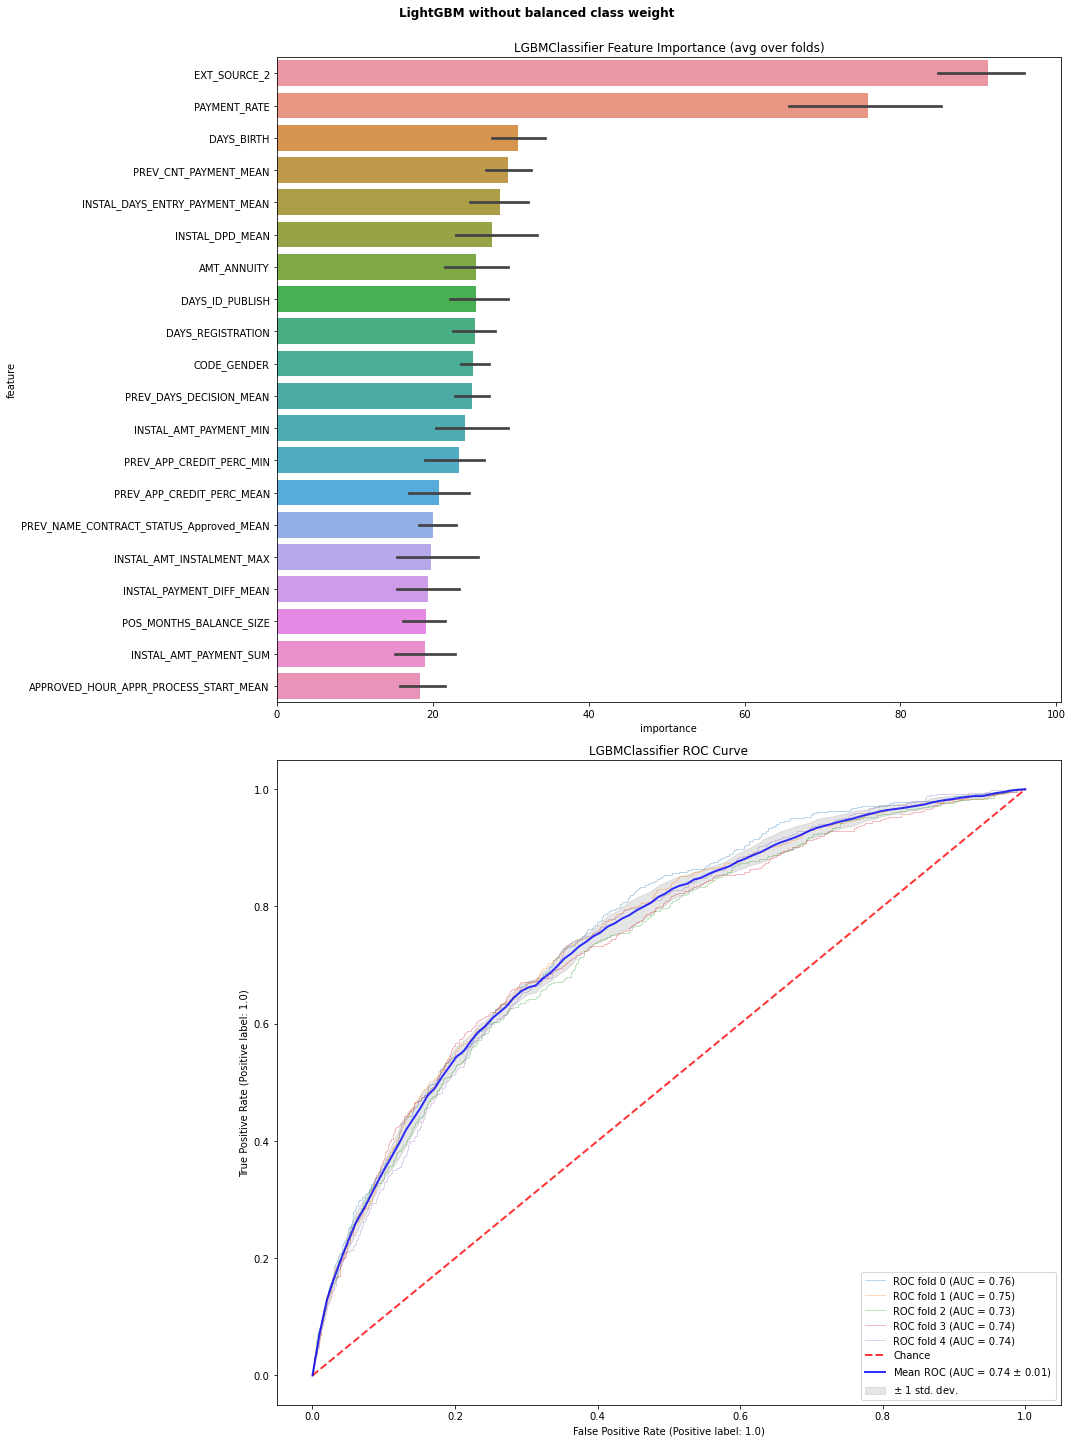

In [12]:
from lightgbm import LGBMClassifier

gridParams = {
    'num_leaves': [8, 16, 34],  # Shall be smaller than 2^(max_depth)
    'max_depth': [8],
    'min_child_samples': [100, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.1, 0.3, 0.5],  # Alias for feature_fraction
}

# Initiate classifier to use
clf = LGBMClassifier( 
    objective='binary', 
    n_jobs=8,
    verbose=-1,
    force_row_wise=True,
)

train_df, _ = train_test_split(data_sampling)
X, y = feats_target_split(train_df)
lgbm_grid = gscv_classifier(X, y, gridParams, clf)
_ = plot_balanced_classifier(X, y, lgbm_grid.best_estimator_, "LightGBM without balanced class weight")

Train shape: (30846, 425), test shape: (4780, 425)
Conteur de class Counter({0.0: 28379, 1.0: 2467})
Starting LGBMClassifier
Fitting 4 folds for each of 54 candidates, totalling 216 fits
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_leaves=8; total time=   0.6s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_leaves=8; total time=   0.8s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_leaves=8; total time=   0.7s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_leaves=8; total time=   0.7s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_leaves=16; total time=   0.8s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_leaves=16; total time=   0.8s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=8, min_child_samples=100, num_

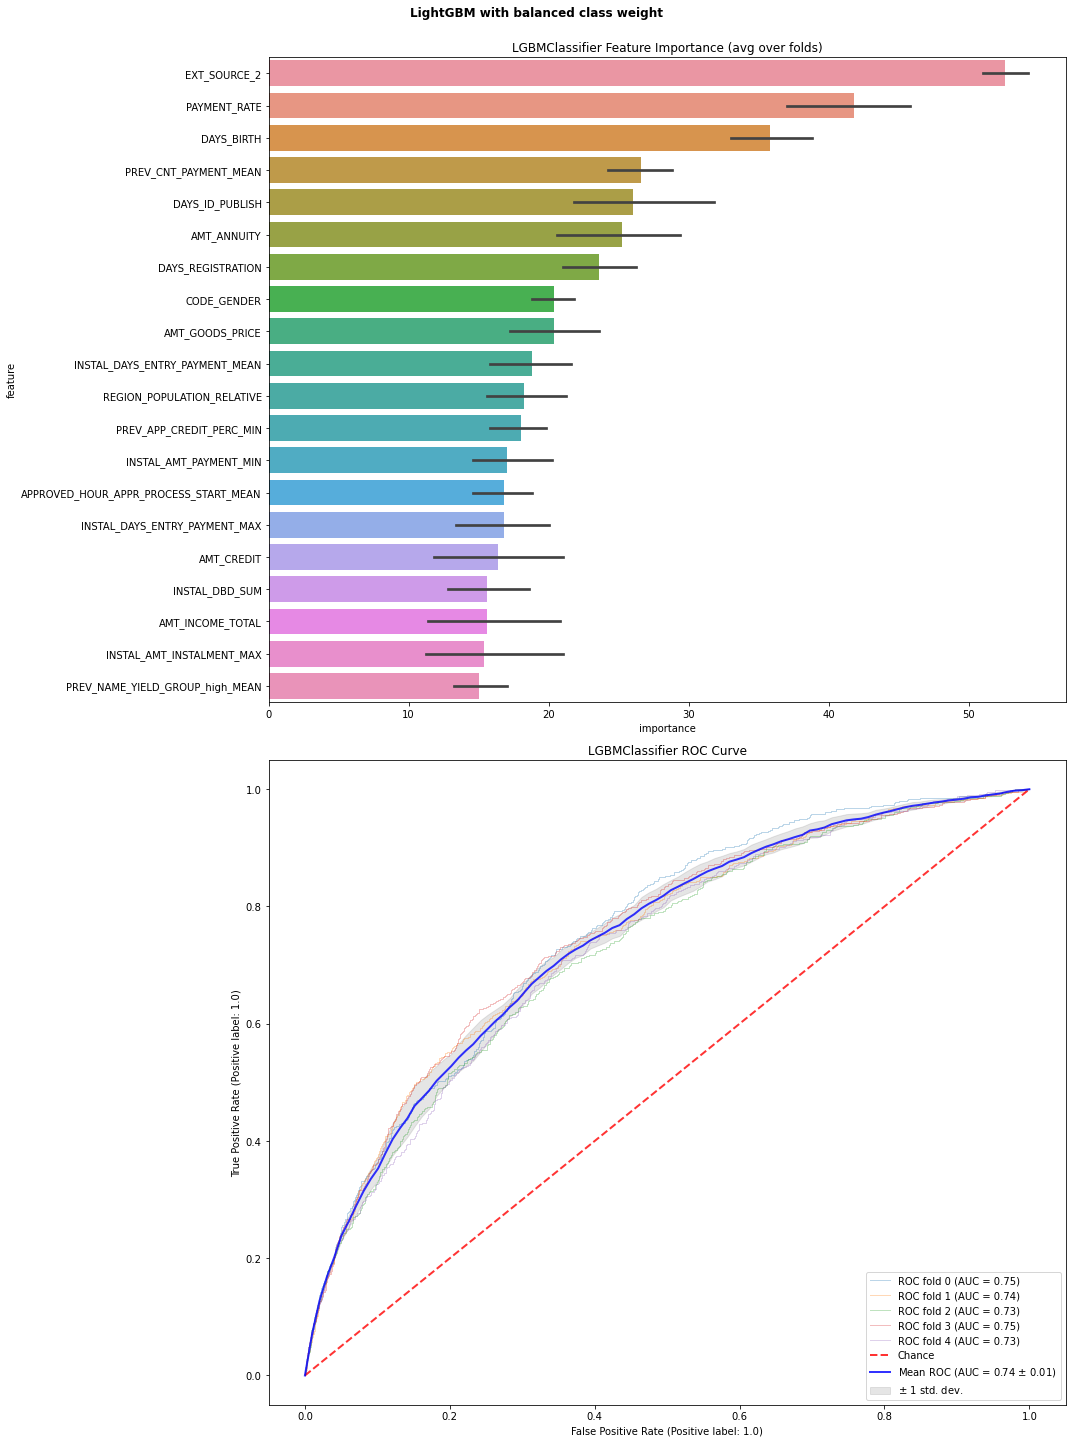

LGBMClassifier(colsample_bytree=0.5, force_row_wise=True, is_unbalance=True,
               max_depth=8, min_child_samples=1000, n_jobs=8, num_leaves=16,
               objective='binary', verbose=-1)

In [13]:
from lightgbm import LGBMClassifier

gridParams = {
    'num_leaves': [8, 16, 34],  # Shall be smaller than 2^(max_depth)
    'max_depth': [8],
    'min_child_samples': [100, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.1, 0.3, 0.5],  # Alias for feature_fraction
}

# Initiate classifier to use
clf = LGBMClassifier( 
    objective='binary', 
    n_jobs=8,
    verbose=-1,
    force_row_wise=True,
    is_unbalance=True,  # try to Automatically balance the weight of the dominated labels
)

train_df, _ = train_test_split(data_sampling)
X, y = feats_target_split(train_df)
lgbm_grid = gscv_classifier(X, y, gridParams, clf)
plot_balanced_classifier(X, y, lgbm_grid.best_estimator_, "LightGBM with balanced class weight")

### Test de XGBoost (GridSearchCV)

Train shape: (30846, 425), test shape: (4780, 425)
Conteur de class Counter({0.0: 28379, 1.0: 2467})
Starting XGBClassifier
Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.6; total time=  10.6s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.6; total time=   9.5s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.6; total time=   9.0s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.6; total time=   8.9s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.9; total time=   9.0s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.9; total time=   9.0s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.9; total time=   9.0s
[C

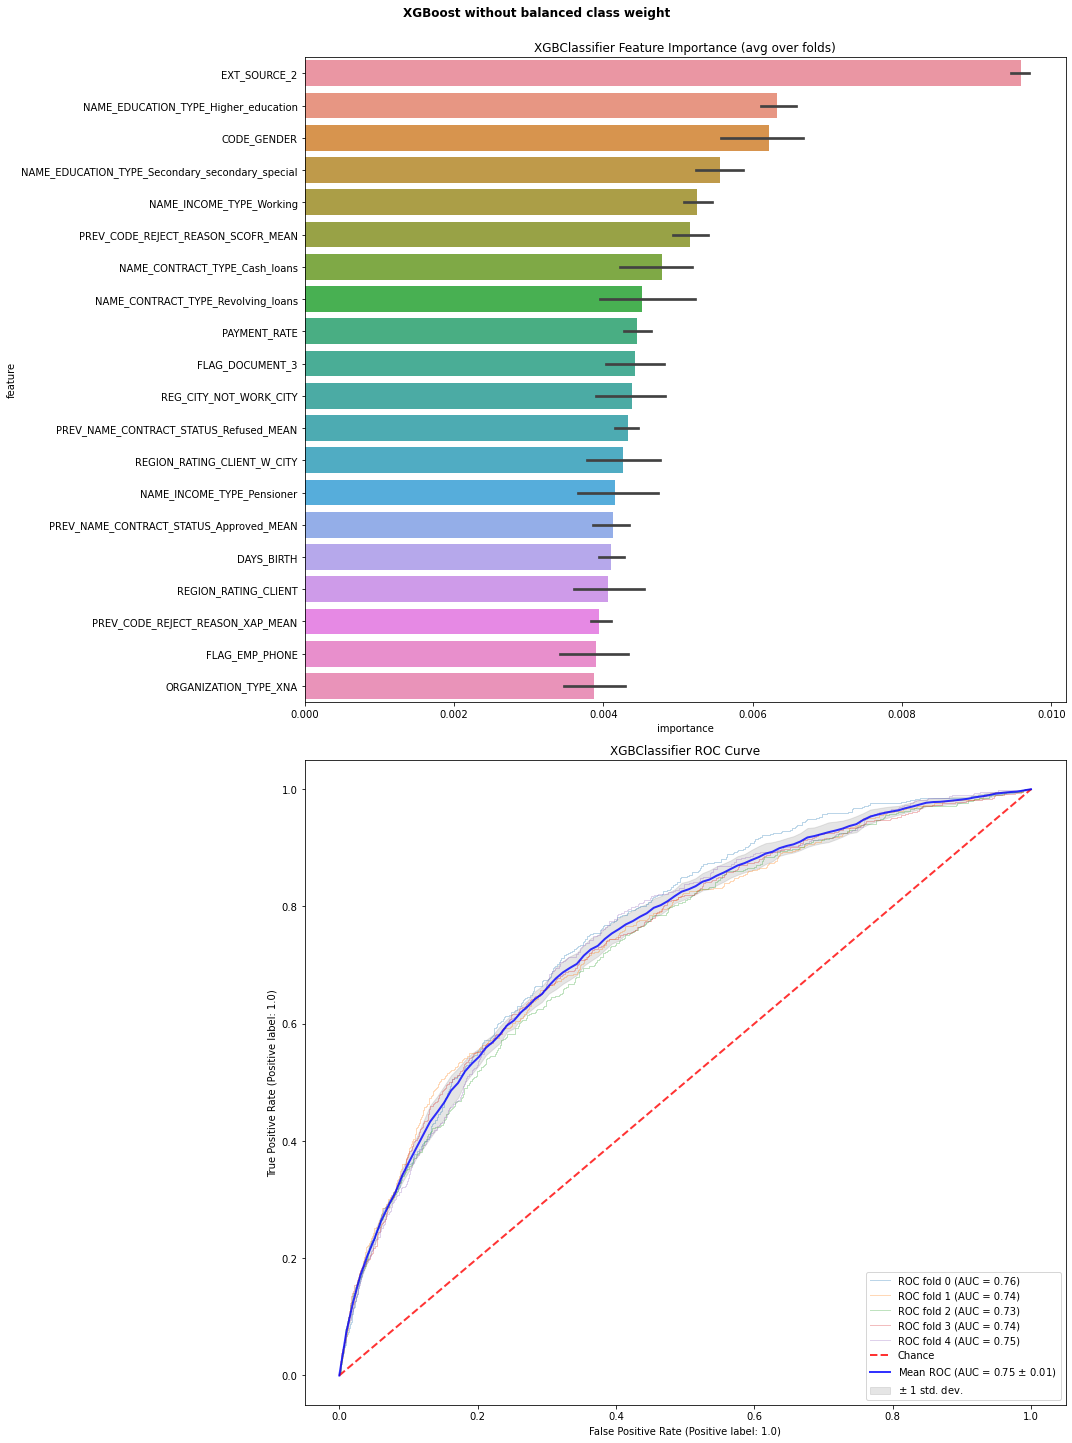

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, error_score='raise', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=8, nthread=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [14]:
from xgboost import XGBClassifier

gridParams = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.6, 0.9],
    'colsample_bytree': [0.1, 0.3],
    'n_estimators': [400, 800]
}

# Initiate classifier to use
clf = XGBClassifier( 
    verbosity=0,
    objective='binary:logistic',
    nthread=8,
    use_label_encoder=False,
    error_score='raise',
)

train_df, _ = train_test_split(data_sampling)
X, y = feats_target_split(train_df)
X.fillna(X.median(), inplace=True)
xgb_grid = gscv_classifier(X, y, gridParams, clf)
plot_balanced_classifier(X, y, xgb_grid.best_estimator_, "XGBoost without balanced class weight")

Train shape: (30846, 425), test shape: (4780, 425)
Conteur de class Counter({0.0: 28379, 1.0: 2467})
Starting XGBClassifier
Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.6; total time=   9.7s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.6; total time=   8.9s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.6; total time=  10.0s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.6; total time=   9.4s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.9; total time=   8.9s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.9; total time=   9.0s
[CV] END colsample_bytree=0.1, learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.9; total time=   9.3s
[C

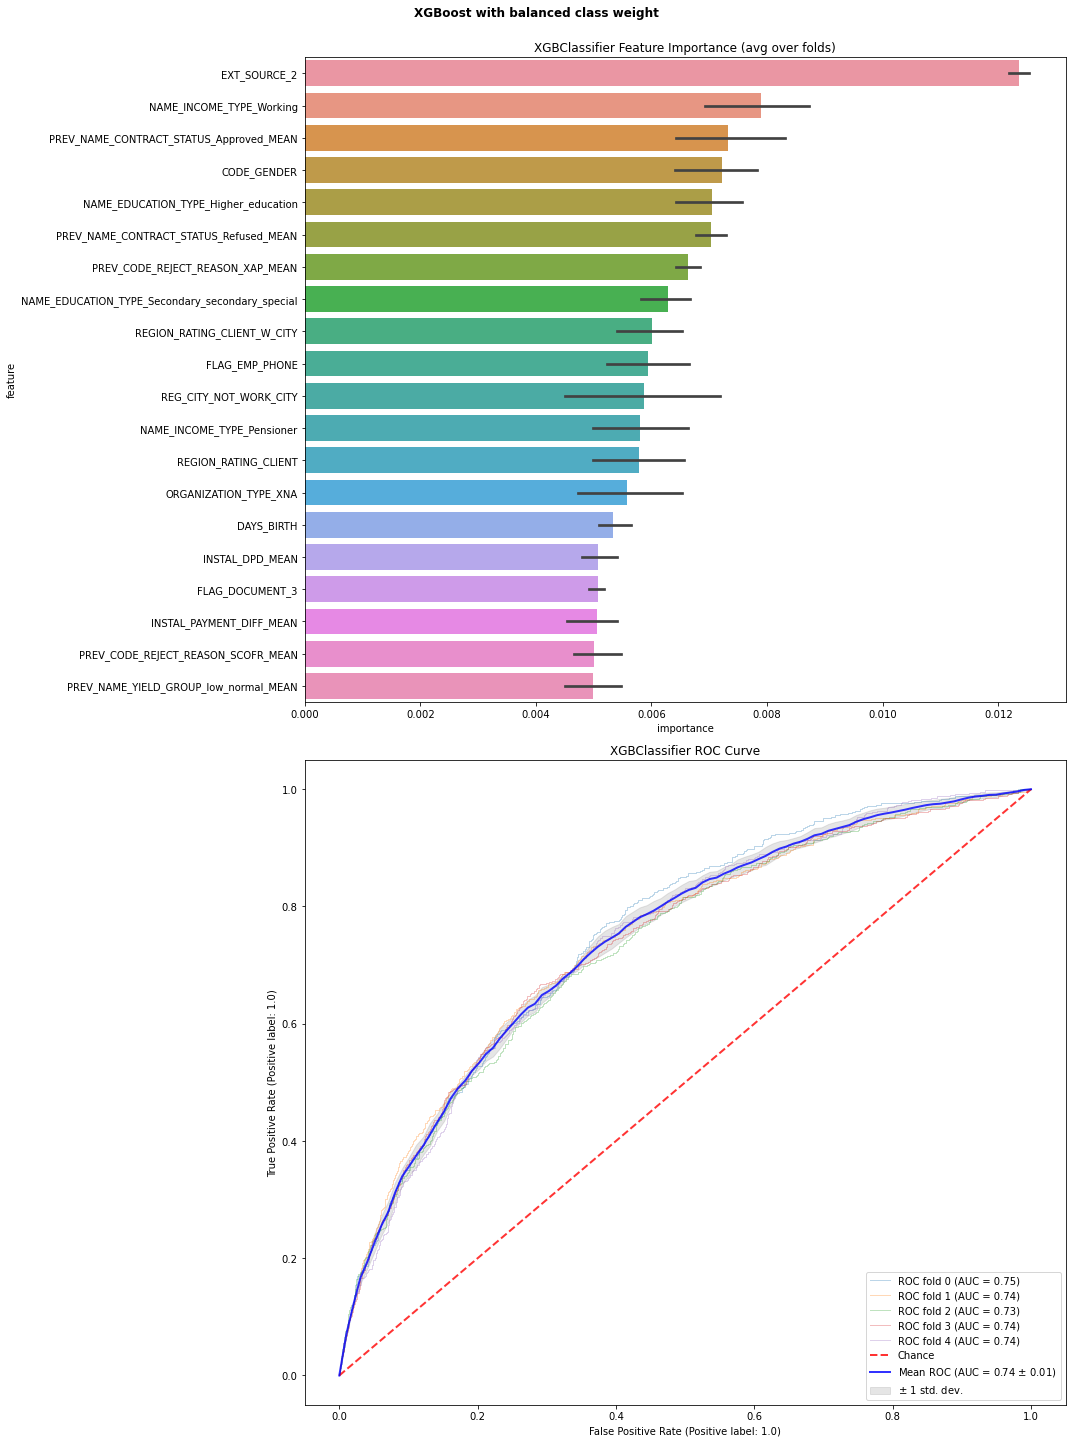

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, error_score='raise', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=8, nthread=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=11.503445480340494, subsample=0.6,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [15]:
from xgboost import XGBClassifier

gridParams = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.6, 0.9],
    'colsample_bytree': [0.1, 0.3],
    'n_estimators': [400, 800]
}

train_df, _ = train_test_split(data_sampling)
X, y = feats_target_split(train_df)
X.fillna(X.median(), inplace=True)
positive_class = y.sum()
negatvie_class = len(y) - positive_class
scale_pos_weight = negatvie_class / positive_class

# Initiate classifier to use
clf = XGBClassifier( 
    verbosity=0,
    objective='binary:logistic',
    nthread=8,
    use_label_encoder=False,
    error_score='raise',
    scale_pos_weight=scale_pos_weight,
)

xgb_grid = gscv_classifier(X, y, gridParams, clf)
plot_balanced_classifier(X, y, xgb_grid.best_estimator_, "XGBoost with balanced class weight")

### Test de RandomForest (GridSearchCV)

Train shape: (30846, 425), test shape: (4780, 425)
Conteur de class Counter({0.0: 28379, 1.0: 2467})
Starting RandomForestClassifier
Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=100; total time=  23.4s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=100; total time=   0.8s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=100; total time=   0.8s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=100; total time=   0.7s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=400; total time=   2.2s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=400; total time=   2.1s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=400; total time=   2.1s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=400; total time=   2.2s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=700; total time=   3.4s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=700; total time=   3

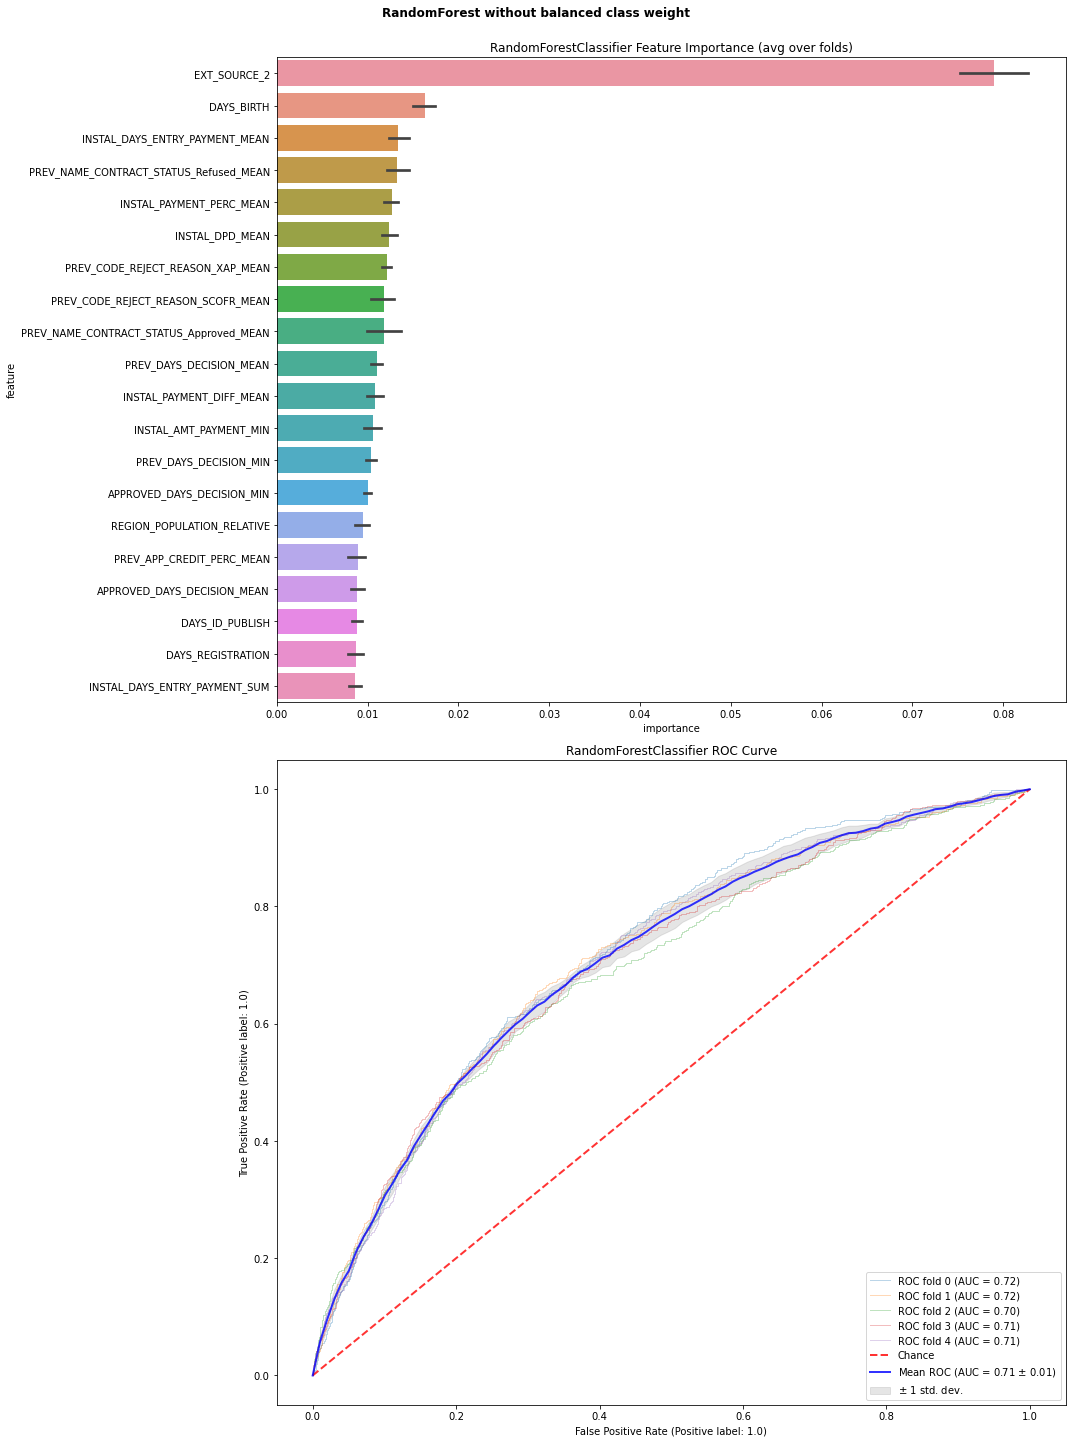

RandomForestClassifier(max_depth=6, max_samples=0.5, n_estimators=700, n_jobs=8)

In [16]:
from sklearn.ensemble import RandomForestClassifier

gridParams = {
    'n_estimators': [100, 400, 700],
    'max_depth': [3, 4, 5, 6],
    'max_samples': [0.5, 1],
}

# Initiate classifier to use
clf = RandomForestClassifier(
    n_jobs=8,
    verbose=0,
)

train_df, _ = train_test_split(data_sampling)
X, y = feats_target_split(train_df)
X.fillna(X.median(), inplace=True)
rfc_grid = gscv_classifier(X, y, gridParams, clf)
plot_balanced_classifier(X, y, rfc_grid.best_estimator_, "RandomForest without balanced class weight")

Train shape: (30846, 425), test shape: (4780, 425)
Conteur de class Counter({0.0: 28379, 1.0: 2467})
Starting RandomForestClassifier
Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=100; total time=   0.9s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=100; total time=   1.0s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=100; total time=   1.0s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=100; total time=   1.1s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=400; total time=   2.3s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=400; total time=   2.2s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=400; total time=   2.3s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=400; total time=   2.3s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=700; total time=   3.9s
[CV] END .....max_depth=3, max_samples=0.5, n_estimators=700; total time=   3

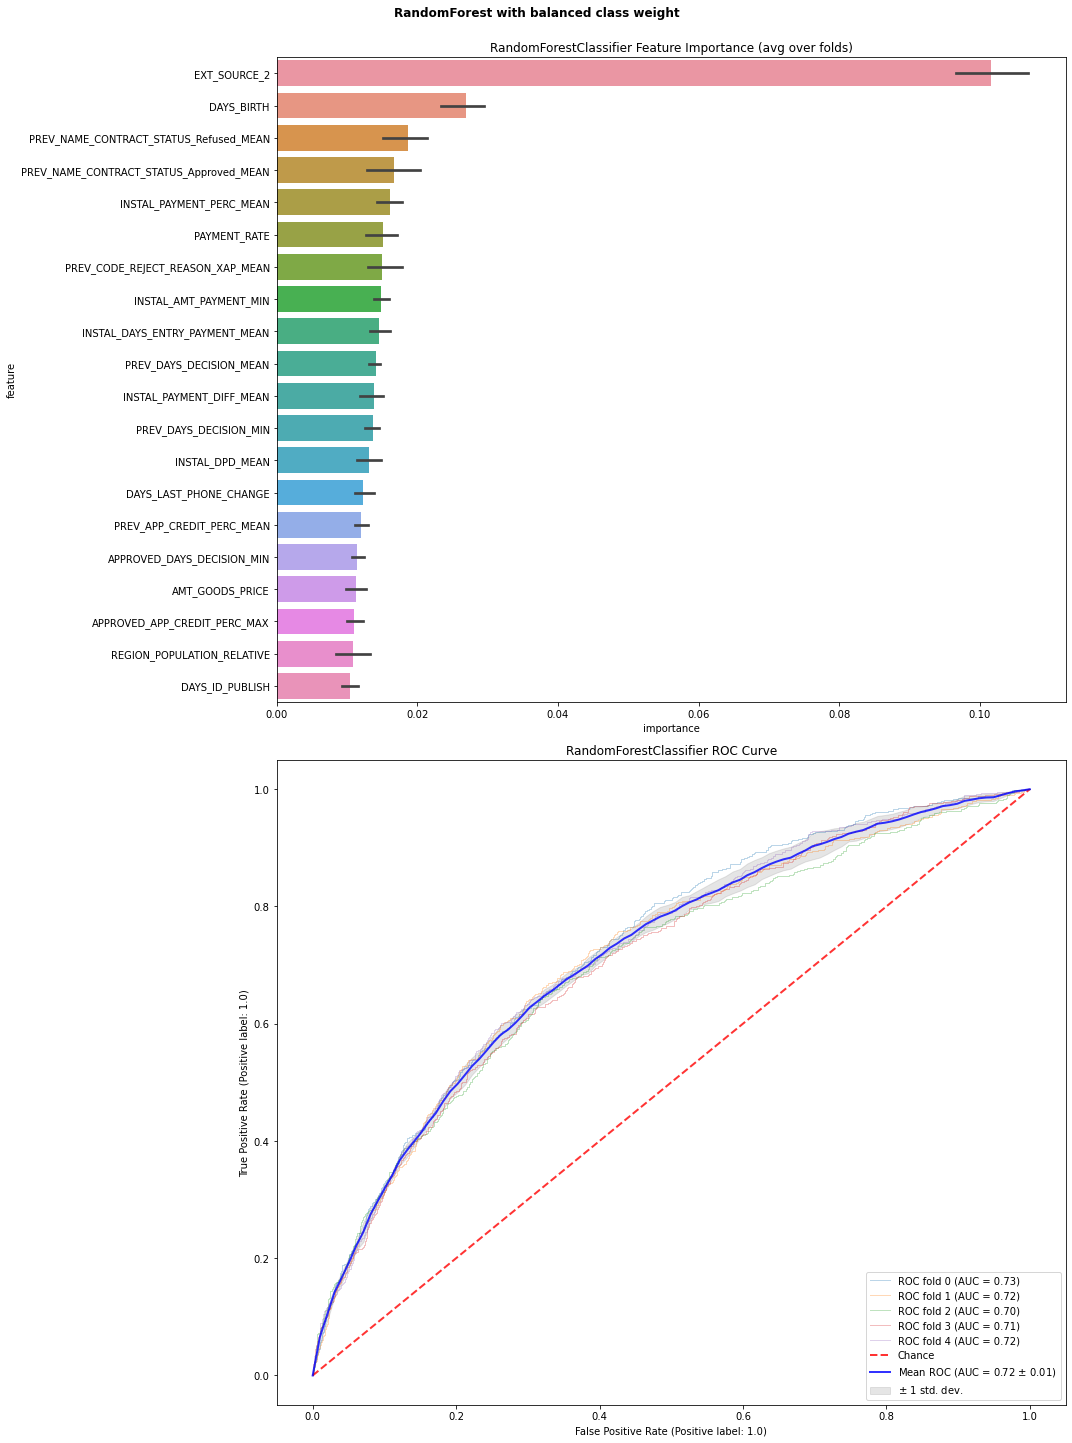

RandomForestClassifier(class_weight='balanced', max_depth=5, max_samples=0.5,
                       n_estimators=400, n_jobs=8)

In [17]:
from sklearn.ensemble import RandomForestClassifier

gridParams = {
    'n_estimators': [100, 400, 700],
    'max_depth': [3, 4, 5, 6],
    'max_samples': [0.5, 1],
}

# Initiate classifier to use
clf = RandomForestClassifier(
    n_jobs=8,
    class_weight='balanced',
    verbose=0,
)

train_df, _ = train_test_split(data_sampling)
X, y = feats_target_split(train_df)
X.fillna(X.median(), inplace=True)
rfc_grid = gscv_classifier(X, y, gridParams, clf)
plot_balanced_classifier(X, y, rfc_grid.best_estimator_, "RandomForest with balanced class weight")

### Over-sampling

In [18]:
import imblearn
print(imblearn.__version__)

train_df, test_df = train_test_split(data_sampling)
X, y = feats_target_split(train_df)
X.fillna(X.median(), inplace=True)

0.7.0
Train shape: (30846, 425), test shape: (4780, 425)
Conteur de class Counter({0.0: 28379, 1.0: 2467})


In [19]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# summarize class distribution
counter = Counter(y)
print("Before resampling:", counter)
print("Ratio of positive class: {}".format(counter[1] / len(y)))

# transform the dataset
over = SMOTE()
# transform the dataset
oX, oy = over.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(oy)
print(counter)

Before resampling: Counter({0.0: 28379, 1.0: 2467})
Ratio of positive class: 0.07997795500226934
Counter({0.0: 28379, 1.0: 28379})


Train shape: (30846, 425), test shape: (4780, 425)
Conteur de class Counter({0.0: 28379, 1.0: 2467})
Ploting LGBMClassifier
Oversampling...
Conteur de class, fold 0: Counter({0.0: 22703, 1.0: 22703})
Fold  1 AUC : 0.719533
Oversampling...
Conteur de class, fold 1: Counter({0.0: 22703, 1.0: 22703})
Fold  2 AUC : 0.695094
Oversampling...
Conteur de class, fold 2: Counter({0.0: 22703, 1.0: 22703})
Fold  3 AUC : 0.705016
Oversampling...
Conteur de class, fold 3: Counter({0.0: 22703, 1.0: 22703})
Fold  4 AUC : 0.718867
Oversampling...
Conteur de class, fold 4: Counter({0.0: 22704, 1.0: 22704})
Fold  5 AUC : 0.711065


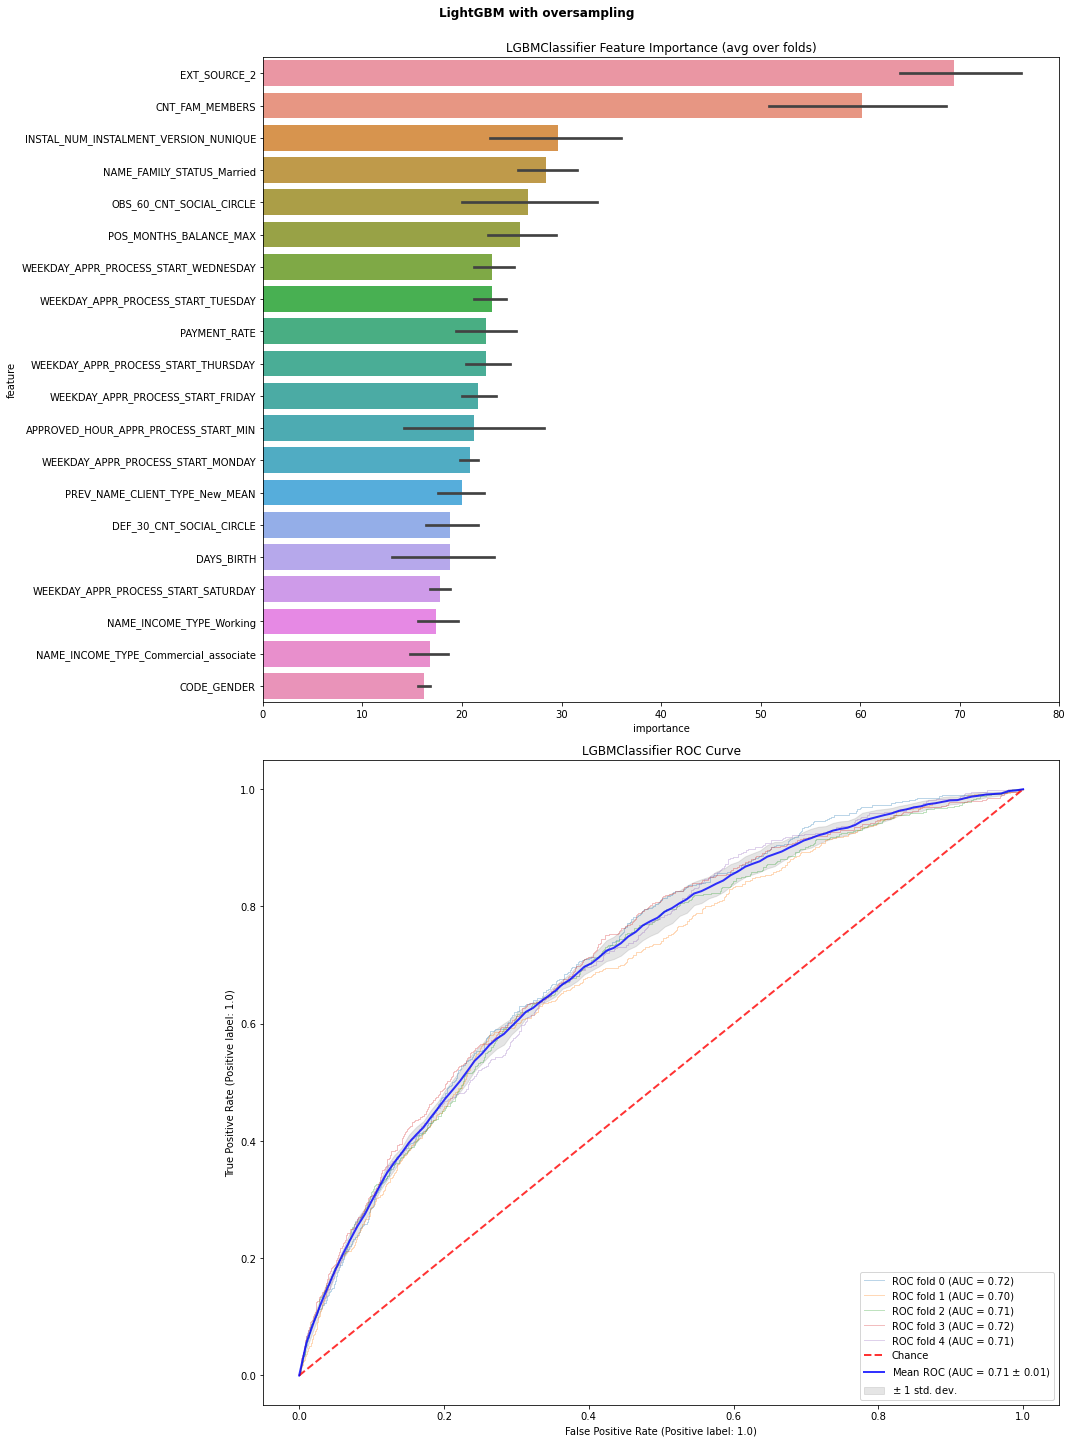

LGBMClassifier(colsample_bytree=0.5, force_row_wise=True, is_unbalance=True,
               max_depth=8, min_child_samples=1000, n_jobs=8, num_leaves=16,
               objective='binary', verbose=-1)

In [20]:
from lightgbm import LGBMClassifier

# Initiate classifier to use
clf = LGBMClassifier(
    objective='binary',
    n_jobs=8,
    verbose=-1,
    force_row_wise=True,
    is_unbalance=True,  # try to Automatically balance the weight of the dominated labels
    num_leaves=16,  # Shall be smaller than 2^(max_depth)
    max_depth=8,
    min_child_samples=1000,
    learning_rate=0.1,
    colsample_bytree=0.5,  # Alias for feature_fraction
)

train_df, test_df = train_test_split(data_sampling)
X, y = feats_target_split(train_df)
X.fillna(X.median(), inplace=True)
plot_balanced_classifier(X, y, clf, "LightGBM with oversampling", oversample=True)

### Under-sampling

In [21]:
import imblearn
print(imblearn.__version__)

train_df, _ = train_test_split(data)
X, y = feats_target_split(train_df)
X.fillna(X.median(), inplace=True)

0.7.0
Train shape: (307511, 425), test shape: (48744, 425)
Conteur de class Counter({0.0: 282686, 1.0: 24825})


In [22]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# summarize class distribution
counter = Counter(y)
print("Before resampling:", counter)
print("Ratio of positive class: {}".format(counter[1] / len(y)))

# transform the dataset
under = RandomUnderSampler()
# transform the dataset
X, y = under.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Before resampling: Counter({0.0: 282686, 1.0: 24825})
Ratio of positive class: 0.08072881945686496
Counter({0.0: 24825, 1.0: 24825})


Train shape: (30846, 425), test shape: (4780, 425)
Conteur de class Counter({0.0: 28379, 1.0: 2467})
Ploting LGBMClassifier
Undersampling...
Conteur de class, fold 0: Counter({0.0: 1973, 1.0: 1973})
Fold  1 AUC : 0.734981
Undersampling...
Conteur de class, fold 1: Counter({0.0: 1974, 1.0: 1974})
Fold  2 AUC : 0.717625
Undersampling...
Conteur de class, fold 2: Counter({0.0: 1974, 1.0: 1974})
Fold  3 AUC : 0.707004
Undersampling...
Conteur de class, fold 3: Counter({0.0: 1974, 1.0: 1974})
Fold  4 AUC : 0.725478
Undersampling...
Conteur de class, fold 4: Counter({0.0: 1973, 1.0: 1973})
Fold  5 AUC : 0.719662


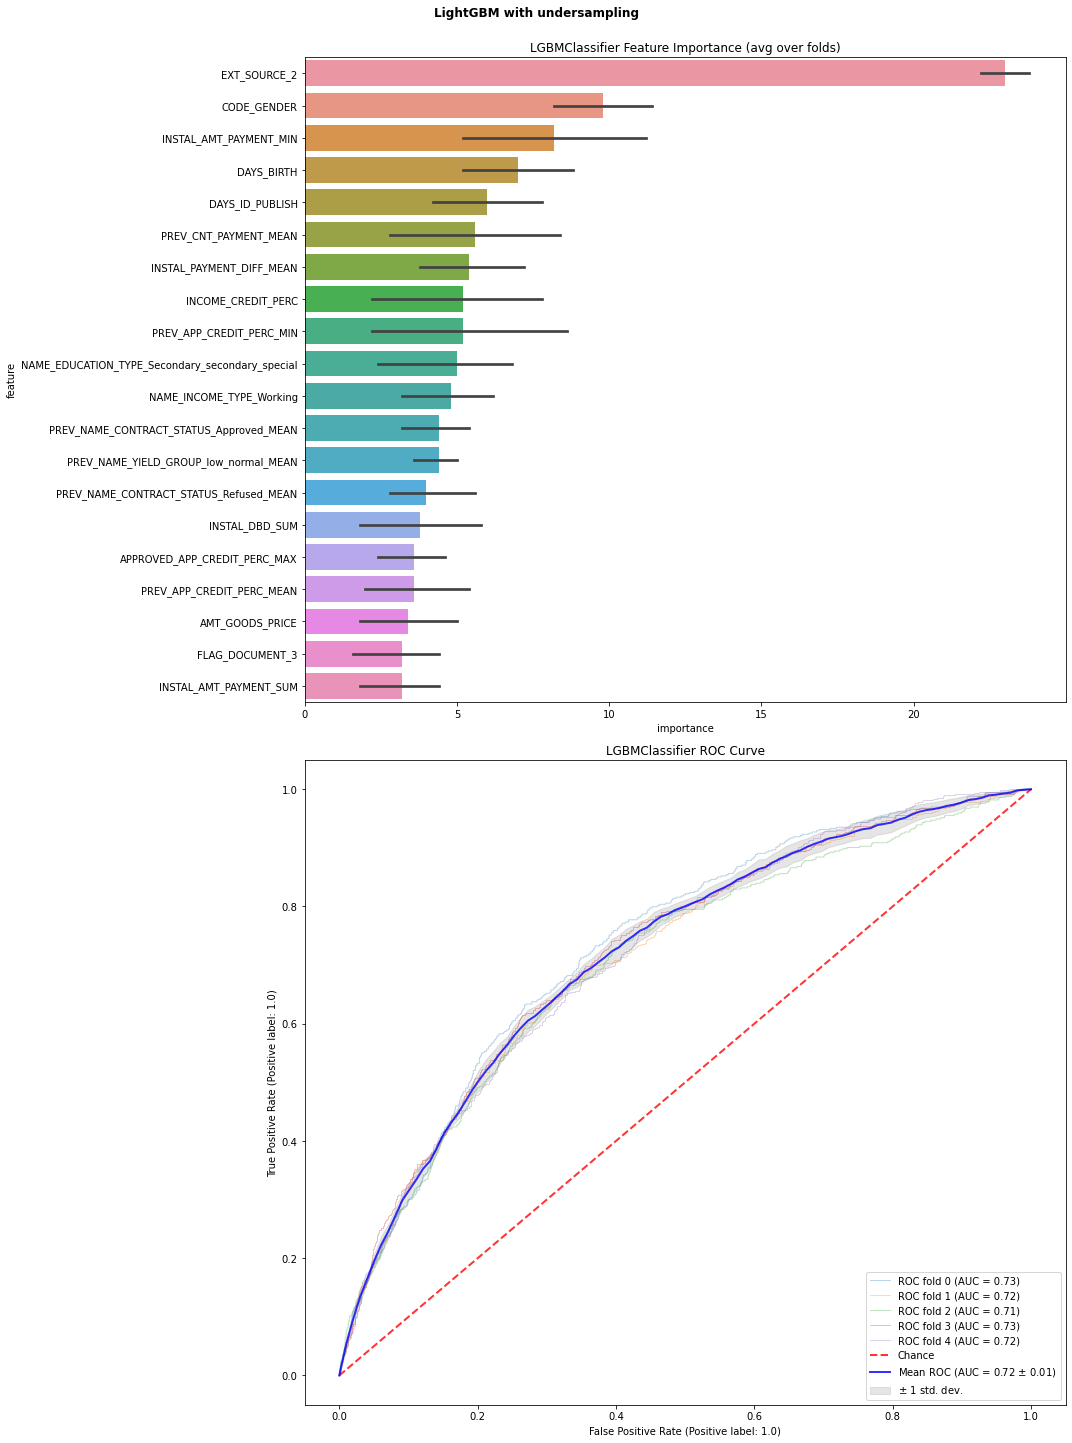

LGBMClassifier(colsample_bytree=0.5, force_row_wise=True, is_unbalance=True,
               max_depth=8, min_child_samples=1000, n_jobs=8, num_leaves=16,
               objective='binary', verbose=-1)

In [23]:
from lightgbm import LGBMClassifier

# Initiate classifier to use
clf = LGBMClassifier(
    objective='binary',
    n_jobs=8,
    verbose=-1,
    force_row_wise=True,
    is_unbalance=True,  # try to Automatically balance the weight of the dominated labels
    num_leaves=16,  # Shall be smaller than 2^(max_depth)
    max_depth=8,
    min_child_samples=1000,
    learning_rate=0.1,
    colsample_bytree=0.5,  # Alias for feature_fraction
)

train_df, test_df = train_test_split(data_sampling)
X, y = feats_target_split(train_df)
X.fillna(X.median(), inplace=True)
plot_balanced_classifier(X, y, clf, "LightGBM with undersampling", undersample=True)

### Mixed Over/Under-sampling

In [24]:
import imblearn
print(imblearn.__version__)

train_df, _ = train_test_split(data_sampling)
X, y = feats_target_split(train_df)
X.fillna(X.median(), inplace=True)

0.7.0
Train shape: (30846, 425), test shape: (4780, 425)
Conteur de class Counter({0.0: 28379, 1.0: 2467})


In [25]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# summarize class distribution
counter = Counter(y)
print("Before resampling:", counter)
print("Ratio of positive class: {}".format(counter[1] / len(y)))

# transform the dataset
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Before resampling: Counter({0.0: 28379, 1.0: 2467})
Ratio of positive class: 0.07997795500226934
Counter({0.0: 5674, 1.0: 2837})


Train shape: (30846, 425), test shape: (4780, 425)
Conteur de class Counter({0.0: 28379, 1.0: 2467})
Ploting LGBMClassifier
Pipeline Oversampling and Undersampling...
Conteur de class, fold 0: Counter({0.0: 4540, 1.0: 2270})
Fold  1 AUC : 0.744904
Pipeline Oversampling and Undersampling...
Conteur de class, fold 1: Counter({0.0: 4540, 1.0: 2270})
Fold  2 AUC : 0.728864
Pipeline Oversampling and Undersampling...
Conteur de class, fold 2: Counter({0.0: 4540, 1.0: 2270})
Fold  3 AUC : 0.722399
Pipeline Oversampling and Undersampling...
Conteur de class, fold 3: Counter({0.0: 4540, 1.0: 2270})
Fold  4 AUC : 0.736994
Pipeline Oversampling and Undersampling...
Conteur de class, fold 4: Counter({0.0: 4540, 1.0: 2270})
Fold  5 AUC : 0.728496


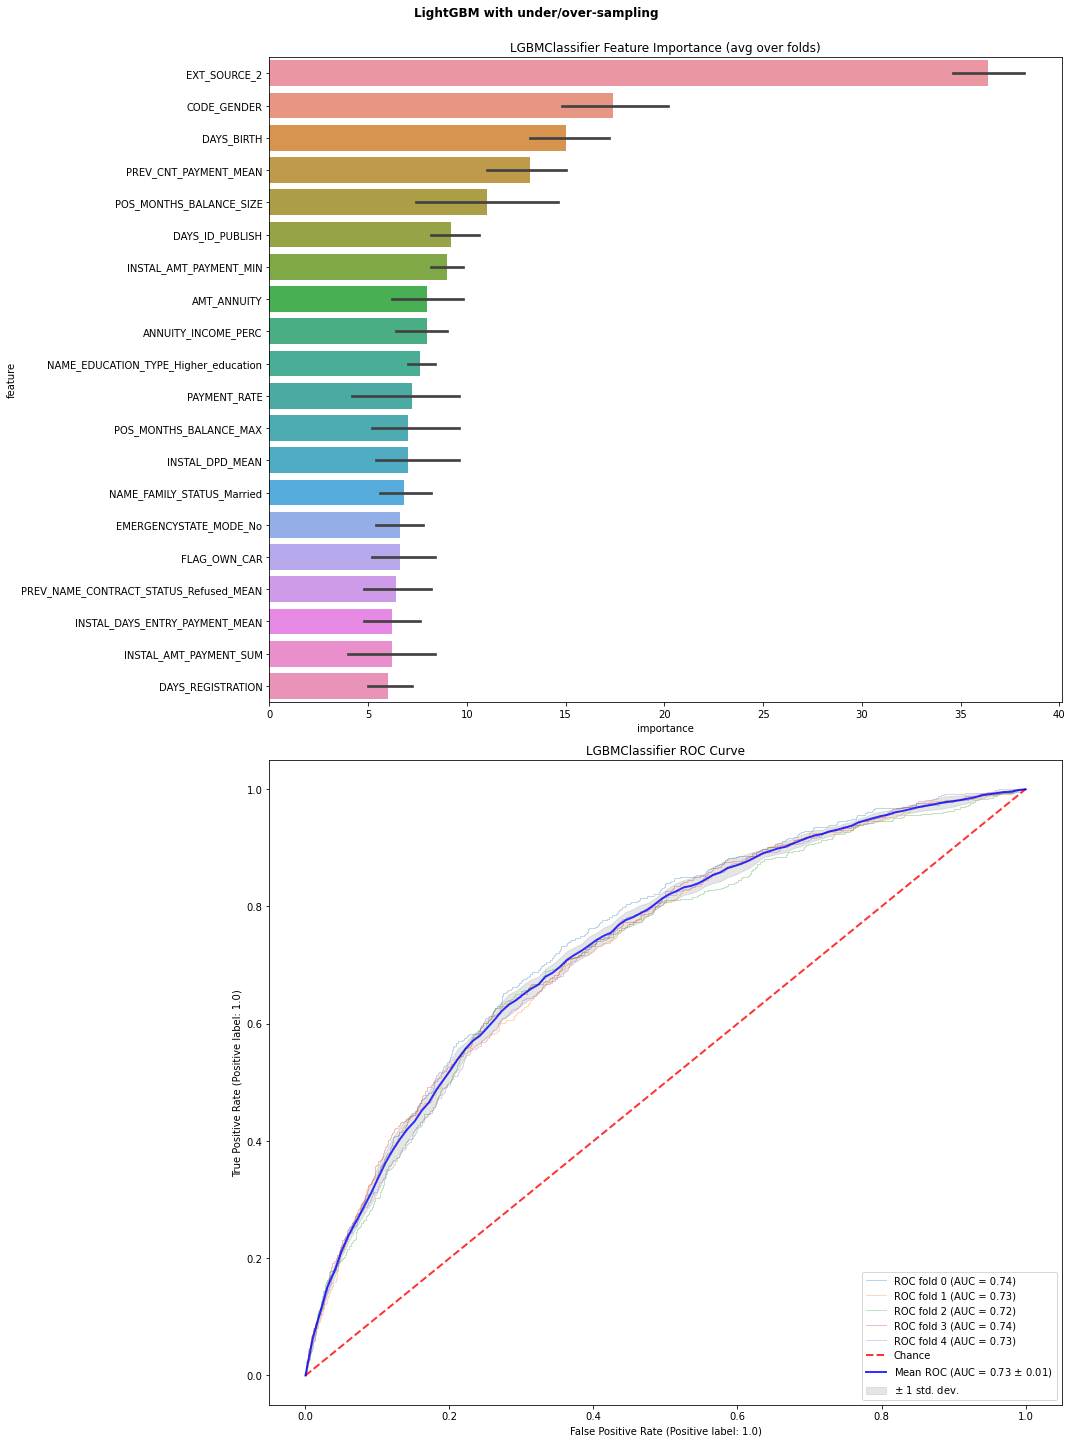

LGBMClassifier(colsample_bytree=0.5, force_row_wise=True, is_unbalance=True,
               max_depth=8, min_child_samples=1000, n_jobs=8, num_leaves=16,
               objective='binary', verbose=-1)

In [26]:
from lightgbm import LGBMClassifier

# Initiate classifier to use
clf = LGBMClassifier(
    objective='binary',
    n_jobs=8,
    verbose=-1,
    force_row_wise=True,
    is_unbalance=True,  # try to Automatically balance the weight of the dominated labels
    num_leaves=16,  # Shall be smaller than 2^(max_depth)
    max_depth=8,
    min_child_samples=1000,
    learning_rate=0.1,
    colsample_bytree=0.5,  # Alias for feature_fraction
)

train_df, test_df = train_test_split(data_sampling)
X, y = feats_target_split(train_df)
X.fillna(X.median(), inplace=True)
plot_balanced_classifier(
    X,
    y,
    clf,
    "LightGBM with under/over-sampling",
    undersample=True,
    oversample=True,
    underparams={'sampling_strategy':0.5},
    overparams={'sampling_strategy':0.1}
)

comment sortir un modèle entrainé à partir des folds ?

### Explication avec LIME

In [27]:
train_df, test_df = train_test_split(data_sampling)
X, y = feats_target_split(train_df)
X_test, y_test = feats_target_split(test_df)
X.fillna(X.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)

Train shape: (30846, 425), test shape: (4780, 425)
Conteur de class Counter({0.0: 28379, 1.0: 2467})


In [28]:
from lime import lime_tabular
from lightgbm import LGBMClassifier

# Initiate classifier to use
clf = LGBMClassifier(
    objective='binary',
    n_jobs=8,
    verbose=-1,
    force_row_wise=True,
    is_unbalance=True,  # try to Automatically balance the weight of the dominated labels
    num_leaves=16,  # Shall be smaller than 2^(max_depth)
    max_depth=8,
    min_child_samples=1000,
    learning_rate=0.1,
    colsample_bytree=0.5,  # Alias for feature_fraction
)

clf.fit(X, y, eval_set=[(X, y)], eval_metric='auc', early_stopping_rounds=10)

explainer = lime_tabular.LimeTabularExplainer(
    X.values,
    mode="classification",
    class_names=["0", "1"],
    feature_names=X.columns.to_list(),
)

idx = random.randint(1, len(X_test))

explanation = explainer.explain_instance(X_test.iloc[idx], clf.predict_proba, num_features=len(X.columns))

explanation.show_in_notebook()

[1]	training's auc: 0.656564	training's binary_logloss: 0.284852
[2]	training's auc: 0.688334	training's binary_logloss: 0.302254
[3]	training's auc: 0.728079	training's binary_logloss: 0.318197
[4]	training's auc: 0.742795	training's binary_logloss: 0.335407
[5]	training's auc: 0.750071	training's binary_logloss: 0.352901
[6]	training's auc: 0.755264	training's binary_logloss: 0.369976
[7]	training's auc: 0.758383	training's binary_logloss: 0.386172
[8]	training's auc: 0.762716	training's binary_logloss: 0.402352
[9]	training's auc: 0.765007	training's binary_logloss: 0.416585
[10]	training's auc: 0.767662	training's binary_logloss: 0.429761
[11]	training's auc: 0.768917	training's binary_logloss: 0.442517
[12]	training's auc: 0.771207	training's binary_logloss: 0.45399
[13]	training's auc: 0.773099	training's binary_logloss: 0.464611
[14]	training's auc: 0.77497	training's binary_logloss: 0.473975
[15]	training's auc: 0.777909	training's binary_logloss: 0.482927
[16]	training's auc: 

### Explication avec SHAP

In [29]:
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [30]:
train_df, test_df = train_test_split(data_sampling)
X, y = feats_target_split(train_df)
X_test, y_test = feats_target_split(test_df)
X.fillna(X.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)

Train shape: (30846, 425), test shape: (4780, 425)
Conteur de class Counter({0.0: 28379, 1.0: 2467})


In [31]:
from lightgbm import LGBMClassifier
import shap

# Initiate classifier to use
clf = LGBMClassifier(
    objective='binary',
    n_jobs=8,
    verbose=-1,
    force_row_wise=True,
    is_unbalance=True,  # try to Automatically balance the weight of the dominated labels
    num_leaves=16,  # Shall be smaller than 2^(max_depth)
    max_depth=8,
    min_child_samples=1000,
    learning_rate=0.1,
    colsample_bytree=0.5,  # Alias for feature_fraction
)

clf.fit(X, y, eval_set=[(X, y)], eval_metric='auc', early_stopping_rounds=10)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
sv = np.array(shap_values)
y = clf.predict(X).astype("bool")
sv_positive = sv[:,y,:]
sv_negative = sv[:,~y,:]

[1]	training's auc: 0.656564	training's binary_logloss: 0.284852
[2]	training's auc: 0.688334	training's binary_logloss: 0.302254
[3]	training's auc: 0.728079	training's binary_logloss: 0.318197
[4]	training's auc: 0.742795	training's binary_logloss: 0.335407
[5]	training's auc: 0.750071	training's binary_logloss: 0.352901
[6]	training's auc: 0.755264	training's binary_logloss: 0.369976
[7]	training's auc: 0.758383	training's binary_logloss: 0.386172
[8]	training's auc: 0.762716	training's binary_logloss: 0.402352
[9]	training's auc: 0.765007	training's binary_logloss: 0.416585
[10]	training's auc: 0.767662	training's binary_logloss: 0.429761
[11]	training's auc: 0.768917	training's binary_logloss: 0.442517
[12]	training's auc: 0.771207	training's binary_logloss: 0.45399
[13]	training's auc: 0.773099	training's binary_logloss: 0.464611
[14]	training's auc: 0.77497	training's binary_logloss: 0.473975
[15]	training's auc: 0.777909	training's binary_logloss: 0.482927
[16]	training's auc: 

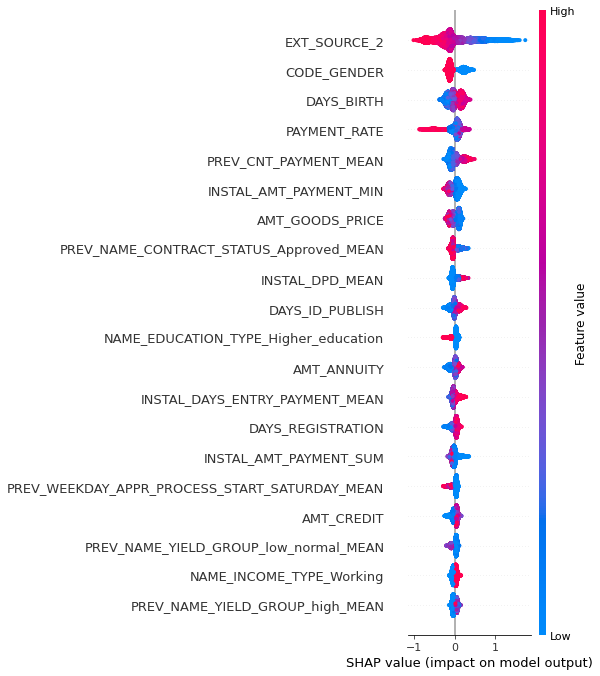

In [32]:
shap.summary_plot(shap_values[1], X.astype("float"))

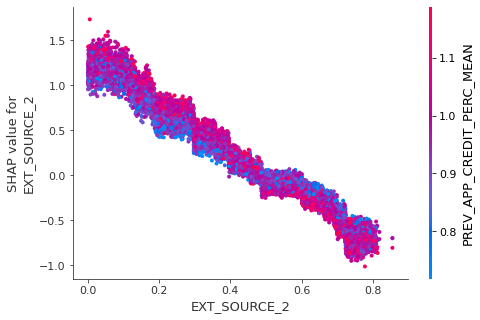

In [33]:
shap.dependence_plot("EXT_SOURCE_2", shap_values[1], X)

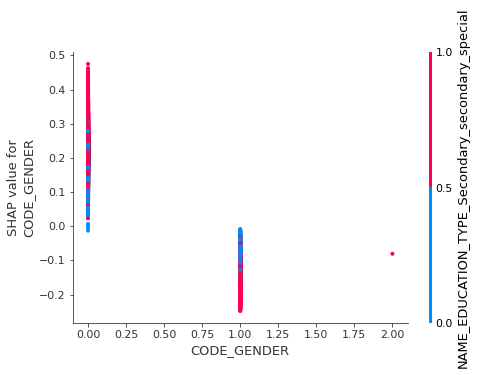

In [34]:
shap.dependence_plot("CODE_GENDER", shap_values[1], X)

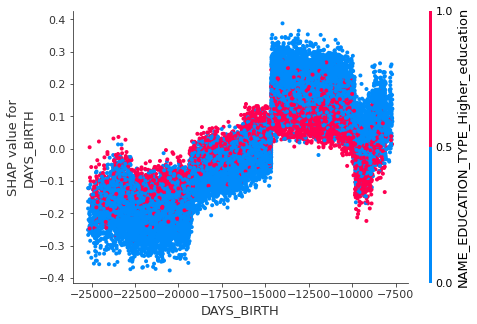

In [35]:
shap.dependence_plot("DAYS_BIRTH", shap_values[1], X)

### Optimisation du modèle

In [36]:
from sklearn.model_selection import train_test_split as sk_train_test_split
train_df, test_df = train_test_split(data)
X, y = feats_target_split(train_df)
X_train, X_test, y_train, y_test = sk_train_test_split(X, y)

Train shape: (307511, 425), test shape: (48744, 425)
Conteur de class Counter({0.0: 282686, 1.0: 24825})


In [37]:
# Minimiser les faux négatifs
from lightgbm import LGBMClassifier

# Initiate classifier to use
clf = LGBMClassifier(
    objective='binary',
    n_jobs=8,
    verbose=-1,
    force_row_wise=True,
    is_unbalance=True,  # try to Automatically balance the weight of the dominated labels
    num_leaves=16,  # Shall be smaller than 2^(max_depth)
    max_depth=8,
    min_child_samples=1000,
    learning_rate=0.1,
    colsample_bytree=0.5,  # Alias for feature_fraction
)

# X_train.fillna(X_train.median(), inplace=True)
clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], eval_metric='auc', early_stopping_rounds=10)

[1]	training's auc: 0.63919	training's binary_logloss: 0.28723
[2]	training's auc: 0.696242	training's binary_logloss: 0.302327
[3]	training's auc: 0.708291	training's binary_logloss: 0.32089
[4]	training's auc: 0.717796	training's binary_logloss: 0.341245
[5]	training's auc: 0.721938	training's binary_logloss: 0.360294
[6]	training's auc: 0.723682	training's binary_logloss: 0.378874
[7]	training's auc: 0.72552	training's binary_logloss: 0.396688
[8]	training's auc: 0.728493	training's binary_logloss: 0.414097
[9]	training's auc: 0.72961	training's binary_logloss: 0.429746
[10]	training's auc: 0.731878	training's binary_logloss: 0.44479
[11]	training's auc: 0.734915	training's binary_logloss: 0.458422
[12]	training's auc: 0.736239	training's binary_logloss: 0.471378
[13]	training's auc: 0.737125	training's binary_logloss: 0.482759
[14]	training's auc: 0.737768	training's binary_logloss: 0.493301
[15]	training's auc: 0.739295	training's binary_logloss: 0.503274
[16]	training's auc: 0.73

LGBMClassifier(colsample_bytree=0.5, force_row_wise=True, is_unbalance=True,
               max_depth=8, min_child_samples=1000, n_jobs=8, num_leaves=16,
               objective='binary', verbose=-1)

In [38]:
predproba = clf.predict_proba(X_test)
predprobapos = predproba[:,1]
print("Proba:", predprobapos)
auc_score = roc_auc_score(y_test, predprobapos)
print("AUC:", auc_score)

Proba: [0.18511533 0.33047083 0.41513223 ... 0.21674607 0.64368859 0.48100921]
AUC: 0.7574614918450082


In [39]:
# minimiser les faux negatifs en pondérant FN et FP
from sklearn.metrics import confusion_matrix
metric_metier = {}
threshold = np.linspace(0,1,101)
for i in threshold:
    print(">> Threshold", i)
    predclass = predprobapos.copy()
    predclass[predclass < i] = 0
    predclass[predclass >= i] = 1
    res = confusion_matrix(y_test, predclass)
    tn, fp, fn, tp = res.ravel()
    print("True negative:", tn)
    print("False positive:", fp)
    metric_metier[i] = (10*fn+fp)
key_min = min(metric_metier, key=metric_metier.get)
print("------------------------------------------------------")
print("Minimum:", key_min)
print("Minimum value:", metric_metier[key_min])

>> Threshold 0.0
True negative: 0
False positive: 70598
>> Threshold 0.01
True negative: 0
False positive: 70598
>> Threshold 0.02
True negative: 0
False positive: 70598
>> Threshold 0.03
True negative: 3
False positive: 70595
>> Threshold 0.04
True negative: 45
False positive: 70553
>> Threshold 0.05
True negative: 125
False positive: 70473
>> Threshold 0.06
True negative: 284
False positive: 70314
>> Threshold 0.07
True negative: 513
False positive: 70085
>> Threshold 0.08
True negative: 824
False positive: 69774
>> Threshold 0.09
True negative: 1234
False positive: 69364
>> Threshold 0.1
True negative: 1690
False positive: 68908
>> Threshold 0.11
True negative: 2234
False positive: 68364
>> Threshold 0.12
True negative: 2850
False positive: 67748
>> Threshold 0.13
True negative: 3586
False positive: 67012
>> Threshold 0.14
True negative: 4429
False positive: 66169
>> Threshold 0.15
True negative: 5280
False positive: 65318
>> Threshold 0.16
True negative: 6267
False positive: 64331


In [40]:
# minimiser les faux negatifs en utilisant le fbeta score
from sklearn.metrics import fbeta_score
metric_metier = {}
threshold = np.linspace(0,1,101)
for i in threshold:
    print(">> Threshold", i)
    predclass = predprobapos.copy()
    predclass[predclass < i] = 0
    predclass[predclass >= i] = 1
    res = fbeta_score(y_test, predclass, beta=2)
    metric_metier[i] = res
key_max = max(metric_metier, key=metric_metier.get)
print("------------------------------------------------------")
print("Maximum:", key_max)
print("Maximum value:", metric_metier[key_max])

>> Threshold 0.0
>> Threshold 0.01
>> Threshold 0.02
>> Threshold 0.03
>> Threshold 0.04
>> Threshold 0.05
>> Threshold 0.06
>> Threshold 0.07
>> Threshold 0.08
>> Threshold 0.09
>> Threshold 0.1
>> Threshold 0.11
>> Threshold 0.12
>> Threshold 0.13
>> Threshold 0.14
>> Threshold 0.15
>> Threshold 0.16
>> Threshold 0.17
>> Threshold 0.18
>> Threshold 0.19
>> Threshold 0.2
>> Threshold 0.21
>> Threshold 0.22
>> Threshold 0.23
>> Threshold 0.24
>> Threshold 0.25
>> Threshold 0.26
>> Threshold 0.27
>> Threshold 0.28
>> Threshold 0.29
>> Threshold 0.3
>> Threshold 0.31
>> Threshold 0.32
>> Threshold 0.33
>> Threshold 0.34
>> Threshold 0.35000000000000003
>> Threshold 0.36
>> Threshold 0.37
>> Threshold 0.38
>> Threshold 0.39
>> Threshold 0.4
>> Threshold 0.41000000000000003
>> Threshold 0.42
>> Threshold 0.43
>> Threshold 0.44
>> Threshold 0.45
>> Threshold 0.46
>> Threshold 0.47000000000000003
>> Threshold 0.48
>> Threshold 0.49
>> Threshold 0.5
>> Threshold 0.51
>> Threshold 0.52
>> Thre

### Export du notebook en HTML

In [42]:
!jupyter nbconvert --config nbconvert/config_html.py

[NbConvertApp] Converting notebook P7_01_notebookexploration.ipynb to html
[NbConvertApp] Writing 4623390 bytes to P7_01_notebookexploration.html
[NbConvertApp] Converting notebook P7_02_notebookscoring.ipynb to html
[NbConvertApp] Writing 4442393 bytes to P7_02_notebookscoring.html
[NbConvertApp] Converting notebook P7_03_notebookdashboard.ipynb to html
C:\Users\flori\miniconda3\envs\jupyter\lib\site-packages\nbconvert\filters\datatypefilter.py:39: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.plotly.v1+json']) is not able to be represented.
  warn("Your element with mimetype(s) {mimetypes}"
[NbConvertApp] Writing 901023 bytes to P7_03_notebookdashboard.html
